In [26]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import random
import copy
import datetime
import re
from collections import defaultdict
from heapq import *
import math
import numpy as np
import pickle
import requests
import os

In [27]:
#関数パート
def pathtovalleyfree5(inPath,node):
  vtypestr=""
  path2=inPath+[node]
  # print(inPath,path2,"node",node)
  for i in range(len(path2)):
    try:
      vtypestr+=str(G.edges[[path2[i],path2[i+1]]]["vtype"])  
      # print("try")                    #エッジのｐｐｃｐｐｃの順番の文字列
    except:
      # print("exc")
      pass

  # print("vtystr:",vtypestr)
  if vtypestr.count("6")>1 or re.findall(".*4.*2.*",vtypestr) or re.findall(".*4.*6.*",vtypestr) or re.findall(".*6.*2.*",vtypestr):  #不可能な文字列だと
    return False 
  else:
    return True


def gdijkstra5(f):
    q, seen, mins = [(0,f,[])], set(), {f: [0,[f]]}
    seen.add(f)
    for v2 in list(G.neighbors(f)):
      c =G.edges[f,v2]["weight"]
      mins[v2] = [c,[f,v2]]
      heappush(q, (c, v2, [f]))
    while q:
      (cost,v1,path) = heappop(q)
      # print(cost,v1,path, q, seen, mins)
      if v1 not in seen:
          seen.add(v1)
          path3=path+[v1]
          # if len(mins)==G.number_of_nodes(): return sorted(mins)
          for v2 in list(G.neighbors(v1)):
              c =G.edges[v1,v2]["weight2"]
              # print("v1:",v1,"v2:",v2,c)
              if v2 in seen : continue
              prev = mins.get(v2, None)
              next = cost + c
              if (prev is None or next < prev[0]) and pathtovalleyfree5(path3,v2):
                  mins[v2] = [next,path3+[v2]]
                  heappush(q, (next, v2, path3))
    del mins[f]
    return mins

#導入率を受けとり、２パターンの導入率におけるダメージ量の属性を初期化、１パターン非導入２パターン非導入１２パたRPKI色
def dep_sta(rate):
  dep_AS=random.sample(node_list,int(len(node_list)*rate/100)) #ある導入率をもとにランダムに選出
  ndep_AS=[i for i in node_list if i not in dep_AS]
  
  top_dep_AS=[pair[0] for pair in sorted(list(G.degree()),reverse=True,key=lambda x:x[1])[0:int(len(node_list)*rate/100)]] #ある導入率をもとに次数順に選出
  top_ndep_AS=[i for i in node_list if i not in top_dep_AS]

  for AS in ndep_AS:
    G.nodes[AS]["rpki"]="r"
    G.nodes[AS]["Cost"]=0
    G.nodes[AS]['damage0']=0
    # G.nodes[AS]['hdamage']=0
    # G.nodes[AS]['nodepDamage']=0
  for AS in dep_AS:
    G.nodes[AS]["rpki"]="b"
    G.nodes[AS]["Cost"]=cost*math.log(nx.degree(G)[AS])
    G.nodes[AS]['damage0']=0
    # G.nodes[AS]['hdamage']=0
    # G.nodes[AS]['nodepDamage']=0
  for AS in top_dep_AS:
    G.nodes[AS]["top_rpki"]="b"
    G.nodes[AS]["top_Cost"]=cost*math.log(nx.degree(G)[AS])
    G.nodes[AS]['damage1']=0
  for AS in top_ndep_AS:
    G.nodes[AS]["top_rpki"]="r"
    G.nodes[AS]["top_Cost"]=0
    G.nodes[AS]['damage1']=0
   
  return (ndep_AS,top_ndep_AS,[G.nodes[AS]['rpki'] for AS in node_list],[G.nodes[AS]['top_rpki'] for AS in node_list],dep_AS,top_dep_AS) #ランダム選出AS、次数順選出AS、ランダム順色、次数順色

#導入率を受け取り、ダメージを受けるASを計算して、２パターンのダメージ量を返す
def ratio_damage(ratio):
  ndep=dep_sta(ratio)
  for i in [0,1]:
    #中間ASが導入していないことによりダメージを受けるODのペア
    damage_add=set()
    #0:ランダムにチョイスする 1:次数順に導入する
    for AS in ndep[i]:
      try:
        for od_pair_bymidAS in AS_OD_dic[AS]:
          damage_add.add(od_pair_bymidAS)
        for od_pair_byoriginal in OD_pair[AS]:
          damage_add.add(od_pair_byoriginal)
      except:
        pass
    for (origin,destination) in damage_add:
      G.nodes[origin]['damage'+str(i)]+= int(nx.degree(G)[origin]/2) * int(nx.degree(G)[destination]/2)
      G.nodes[destination]['damage'+str(i)]+=int(nx.degree(G)[destination]/2) * int(nx.degree(G)[origin]/2)

  return ([G.nodes[AS]['nodepDamage']-G.nodes[AS]['damage0']- G.nodes[AS]['Cost'] for AS in node_list],[G.nodes[AS]['nodepDamage']- G.nodes[AS]['damage1'] - G.nodes[AS]['top_Cost']for AS in node_list],ndep)#ランダム導入時の損得、次数導入時の損得、上記関数
# 　return ([G.nodes[AS]['nodepDamage']*0.1-G.nodes[AS]['damage0'] for AS in node_list],[G.nodes[AS]['nodepDamage']*0.1-G.nodes[AS]['damage1'] for AS in node_list],ndep)

#ASノード番号を受け取り、それだけ導入にしてそのASの損益値を得る
def ndepAS_benefitorloss(nodenum,ndeplist):
  for AS in node_list:
    G.nodes[AS]['hdamage']=0
  nl=copy.deepcopy(ndeplist)
  nl.remove(nodenum)
  hdamage_add=set()
  for AS in nl:
    try:
      for od_pair_bymidAS in AS_OD_dic[AS]:
        hdamage_add.add(od_pair_bymidAS)
      for od_pair_byoriginal in OD_pair[AS]:
        hdamage_add.add(od_pair_byoriginal)
    except:
      pass
  for (origin,destination) in hdamage_add:
    G.nodes[origin]['hdamage']+= int(nx.degree(G)[origin]/2) * int(nx.degree(G)[destination]/2)
    G.nodes[destination]['hdamage']+=int(nx.degree(G)[destination]/2) * int(nx.degree(G)[origin]/2)
  return G.nodes[nodenum]['nodepDamage']-G.nodes[nodenum]['hdamage']

#ASノード番号を受け取り、それだけ導入にしてそのASの損益値を得るの逆
def depAS_benefitorloss(nodenum,lossattherate):
  return lossattherate - G.nodes[nodenum]['nodepDamage']

def LetsSimulate(RorD,nodeployASlist,deployASlist):
  unk1list=[]
  colorlist=[]
  benefitorlosslist=[G.nodes[AS]['nodepDamage']-G.nodes[AS][f'damage{RorD}']- G.nodes[AS]['Cost'] for AS in node_list]
  while int(len([blue for blue in colorlist if blue=='b'])/len(node_list)) !=1: #導入が100％になるまで

    fN_tD_removelist=[] #導入、非導入に動くASのリスト
    for randomndepnode in nodeployASlist: #ランダム導入で導入していないAS 
      G.nodes[randomndepnode]["rpki"]="r"
      G.nodes[randomndepnode]["Cost"]=0
      G.nodes[randomndepnode][f'damage{RorD}']=0
      G.nodes[randomndepnode]['ifASChangedVal']=ndepAS_benefitorloss(randomndepnode,nodeployASlist)
      if benefitorlosslist[node_list.index(randomndepnode)] < G.nodes[randomndepnode]['ifASChangedVal'] - cost*math.log(nx.degree(G)[randomndepnode]): #自分が導入すると#: #導入していないASで損益が〜を上回ると    
        print('ASischanged=',randomndepnode)
        print(benefitorlosslist[node_list.index(randomndepnode)],'<', G.nodes[randomndepnode]['ifASChangedVal'],'-' ,cost*math.log(nx.degree(G)[randomndepnode]))
        fN_tD_removelist.append(randomndepnode)

    fD_tN_removelist=[] #導入、非導入に動くASのリスト
    for randomdepnode in deployASlist: #ランダム導入で導入AS 
      G.nodes[randomdepnode]["rpki"]="b"
      G.nodes[randomdepnode]["Cost"]=cost*math.log(nx.degree(G)[randomdepnode])
      G.nodes[randomdepnode][f'damage{RorD}']=0
      G.nodes[randomdepnode]['ifASChangedVal']=depAS_benefitorloss(randomdepnode,benefitorlosslist[node_list.index(randomdepnode)])
      if benefitorlosslist[node_list.index(randomdepnode)] < G.nodes[randomdepnode]['ifASChangedVal']:  #導入しているASで損益が〜を下回ると
        print(benefitorlosslist[node_list.index(randomdepnode)],'<',G.nodes[randomdepnode]['ifASChangedVal'])
        print('isremoved=',randomdepnode)
        fD_tN_removelist.append(randomdepnode)

    damage_add=set()
    for AS in nodeployASlist:
        try:
          for od_pair_bymidAS in AS_OD_dic[AS]:
            damage_add.add(od_pair_bymidAS)
          for od_pair_byoriginal in OD_pair[AS]:
            damage_add.add(od_pair_byoriginal)
        except:
          pass
    for (origin,destination) in damage_add:
        G.nodes[origin][f'damage{RorD}']+= int(nx.degree(G)[origin]/2) * int(nx.degree(G)[destination]/2)
        G.nodes[destination][f'damage{RorD}']+=int(nx.degree(G)[destination]/2) * int(nx.degree(G)[origin]/2)
    
    benefitorlosslist=[G.nodes[AS]['nodepDamage']-G.nodes[AS][f'damage{RorD}']- G.nodes[AS]['Cost'] for AS in node_list]
    print(benefitorlosslist)
    print(G.nodes[0][f'damage{RorD}'],G.nodes[0]['nodepDamage'],G.nodes[0]['Cost'])
    benefitlistforplot=[G.nodes[AS]['nodepDamage']-G.nodes[AS][f'damage{RorD}'] for AS in node_list]
    colorlist=[G.nodes[AS]['rpki'] for AS in node_list]

    print(len([blue for blue in colorlist if blue=='b'])/50)
    unk1list.append(len([blue for blue in colorlist if blue=='b'])/50)

    fig = plt.figure()
    plt.title(f'rate={int(100*unk1list[-1])}%,node={len(node_list)}')
    plt.xlabel('AS Index')
    plt.bar(list(range(len(node_list))),[G.nodes[AS]['ifASChangedVal'] if G.nodes[AS]['rpki']=='r' else 0 for AS in node_list],color='r',alpha=0.3)
    plt.scatter(list(range(len(node_list))),benefitlistforplot,color=colorlist,marker="o",s=8)
    plt.plot(list(range(len(node_list))),[cost*math.log(nx.degree(G)[i]) for i in node_list],color='orange',  linestyle='dashed')
    # plt.ylim([-1000,1000])
   
    # plt.plot(list(range(len(node_list))),[G.nodes[AS]['ifASChangedVal'] for AS in node_list if G.nodes[AS]['rpki']=='r'],color='black',  linestyle='dashed')
    plt.show()

    plt.plot(list(range(len(node_list))),benefitorlosslist,color='blue', linestyle='dashdot')
    plt.show()
    title=f'{RorD},cost={cost},rate={rate},nowrate={unk1list[-1]}'
    if not os.path.exists(f'/Users/odrag0n/Downloads/Data file/plots/{datetime.date.today()}'):
      os.makedirs(f'/Users/odrag0n/Downloads/Data file/plots/{datetime.date.today()}')
    fig.savefig(f'//Users/odrag0n/Downloads/Data file/plots/{datetime.date.today()}/{title}.png')
    
    plot_topology(title)

    for AS in fN_tD_removelist:
        nodeployASlist.remove(AS)
        deployASlist.append(AS)
        G.nodes[AS]["rpki"]="b"
        G.nodes[AS]["Cost"]=cost*math.log(nx.degree(G)[randomndepnode])
        G.nodes[AS][f'damage{RorD}']=0
    for AS in fD_tN_removelist:
        deployASlist.remove(AS)
        nodeployASlist.append(AS)
        G.nodes[AS]["rpki"]='r'
        G.nodes[AS]["Cost"]=0
        G.nodes[AS][f'damage{RorD}']=0
  plt.plot(unk1list)

def plot_topology(title):
  pos=nx.spring_layout(G) # positions for all nodes
  fig = plt.figure(figsize = (70, 50))

  nx.draw_networkx_nodes(G,pos,node_color=[G.nodes[i]['rpki'] for i in range(len(node_list))],node_size=800)
  nx.draw_networkx_edges(G,pos,width=1,alpha=0.5,edge_color='black')
  nx.draw_networkx_labels(G,pos,font_size=12,font_family='sans-serif')
  # nx.draw_networkx_edge_labels(G,pos,edgelabeldict)
  # fig.savefig(now+"/content/drive/MyDrive/graphs/グラフ全体図"+"img.png")
  plt.show()
  if not os.path.exists(f'/Users/odrag0n/Downloads/Data file/plots/{datetime.date.today()}'):
      os.makedirs(f'/Users/odrag0n/Downloads/Data file/plots/{datetime.date.today()}')
  fig.savefig(f'//Users/odrag0n/Downloads/Data file/plots/{datetime.date.today()}/topology,{title}.png')


def inRate_toenddeprate(RorD,rate):
  dep_rate=[]
  damage_list=ratio_damage(rate)

  if RorD==0:
    nodeployASlist=damage_list[2][0]
    deployASlist=damage_list[2][4]
  if RorD==1:
    nodeployASlist=damage_list[2][1]
    deployASlist=damage_list[2][5]

  benefitorlosslist=[G.nodes[AS]['nodepDamage']-G.nodes[AS][f'damage{RorD}']- G.nodes[AS]['Cost'] for AS in node_list]
  while int(len([node for node in node_list if G.nodes[node]['Cost']!=0])/len(node_list)) !=1: #導入が100％になるまで

    fN_tD_removelist=[] #導入、非導入に動くASのリスト
    for randomndepnode in nodeployASlist: #ランダム導入で導入していないAS 
      G.nodes[randomndepnode]["Cost"]=0
      G.nodes[randomndepnode][f'damage{RorD}']=0
      G.nodes[randomndepnode]['ifASChangedVal']=ndepAS_benefitorloss(randomndepnode,nodeployASlist)
      if benefitorlosslist[node_list.index(randomndepnode)] < G.nodes[randomndepnode]['ifASChangedVal'] - cost*math.log(nx.degree(G)[randomndepnode]): #自分が導入すると#: #導入していないASで損益が〜を上回ると    
        fN_tD_removelist.append(randomndepnode)

    fD_tN_removelist=[] #導入、非導入に動くASのリスト
    for randomdepnode in deployASlist: #ランダム導入で導入AS 
      G.nodes[randomdepnode]["Cost"]=cost*math.log(nx.degree(G)[randomdepnode])
      G.nodes[randomdepnode][f'damage{RorD}']=0
      G.nodes[randomdepnode]['ifASChangedVal']=depAS_benefitorloss(randomdepnode,benefitorlosslist[node_list.index(randomdepnode)])
      if benefitorlosslist[node_list.index(randomdepnode)] < G.nodes[randomdepnode]['ifASChangedVal']:  #導入しているASで損益が〜を下回ると
        fD_tN_removelist.append(randomdepnode)

    damage_add=set()
    for AS in nodeployASlist:
        try:
          for od_pair_bymidAS in AS_OD_dic[AS]:
            damage_add.add(od_pair_bymidAS)
          for od_pair_byoriginal in OD_pair[AS]:
            damage_add.add(od_pair_byoriginal)
        except:
          pass
    for (origin,destination) in damage_add:
        G.nodes[origin][f'damage{RorD}']+= int(nx.degree(G)[origin]/2) * int(nx.degree(G)[destination]/2)
        G.nodes[destination][f'damage{RorD}']+=int(nx.degree(G)[destination]/2) * int(nx.degree(G)[origin]/2)
    
    benefitorlosslist=[G.nodes[AS]['nodepDamage']-G.nodes[AS][f'damage{RorD}']- G.nodes[AS]['Cost'] for AS in node_list]

    dep_rate.append(int(len([node for node in node_list if G.nodes[node]['Cost']!=0])/len(node_list)*100))
    if len(dep_rate)>2 and dep_rate[-1]==dep_rate[-2]==dep_rate[-3]:
      return dep_rate[-1]

    for AS in fN_tD_removelist:
        nodeployASlist.remove(AS)
        deployASlist.append(AS)
        G.nodes[AS]["Cost"]=cost*math.log(nx.degree(G)[randomndepnode])
        G.nodes[AS][f'damage{RorD}']=0
    for AS in fD_tN_removelist:
        deployASlist.remove(AS)
        nodeployASlist.append(AS)
        G.nodes[AS]["Cost"]=0
        G.nodes[AS][f'damage{RorD}']=0
  return 100

def plot_and_savefig(length,data,title,xlabl,ylabl):
  fig = plt.figure()
  plt.plot(length,data)
  # plt.text(110, 0, 'Hello, World!')
  plt.title(title)
  plt.xlabel(xlabl)
  plt.ylabel(ylabl)
  plt.show()
  if not os.path.exists(f'/Users/odrag0n/Downloads/Data file/plots/{datetime.date.today()}'):
      os.makedirs(f'/Users/odrag0n/Downloads/Data file/plots/{datetime.date.today()}')
  fig.savefig(f'//Users/odrag0n/Downloads/Data file/plots/{datetime.date.today()}/{title}.png')

def linenotify(token,message):
        url = "https://notify-api.line.me/api/notify"
        headers = {"Authorization" : "Bearer "+ token}
        payload = {"message" :  message}
        r = requests.post(url ,headers = headers ,data=payload)

In [62]:
nodenum=50
cost=400
rate = 0

In [63]:
H = nx.random_internet_as_graph(nodenum,seed=None)
G = nx.DiGraph(H)

In [64]:
node_list=sorted(list(G.nodes()), key=lambda x: nx.degree(G)[x],reverse=True)

# mapping = {k: v for k, v in zip(node_list, G.nodes)}
# G = nx.relabel_nodes(G, mapping)
# node_list=sorted(list(G.nodes()), key=lambda x: nx.degree(G)[x],reverse=True)
for edge,ctdict in dict(G.edges).items():
  G.edges[edge]["weight2"]=1
  
  if ctdict["type"]=="transit":
    if str(edge[0])==ctdict["customer"]:
      G.edges[edge]["weight"]=2
      G.edges[edge]["vtype"]="2" 
    else:
      G.edges[edge]["weight"]=0 
      G.edges[edge]["vtype"]="4"
  else:
    G.edges[edge]["weight"]=1
    G.edges[edge]["vtype"]="6"

In [65]:
for node in node_list:
  G.nodes[node]['nodepDamage']=0
  
AS_OD_dic=defaultdict(list)
OD_pair=defaultdict(list)
#始点：node 終点：key
for node in node_list:
  # G.nodes[node]['nodepDamage']=0
  for keys,values in gdijkstra5(node).items():
    #導入がゼロの時のダメージ量の最低を求める
    G.nodes[node]['nodepDamage']+=1 * int(nx.degree(G)[node]/2) * int(nx.degree(G)[keys]/2) 
    G.nodes[keys]['nodepDamage']+=1 * int(nx.degree(G)[node]/2) * int(nx.degree(G)[keys]/2) 
    #その始点ASと終点ASのペアを作る
    OD_pair[node].append((node,keys))
    OD_pair[node].append((keys,node))

    for i in values[1][1:-1]:
      AS_OD_dic[i].append((node,keys))

In [66]:
%%capture result
%%time
linenotify("9UJ32TKI07zAR8xXoBeFWhtIbPanAg8kSKrbWpLBHiI",'######start!######')

##setting##
ratelist=list(range(0,101,5))
costrangelist=list(range(100,1050,50))
randomfulldependlist=[]
degreefulldependlist=[]
check=1000
##end##

for i in [0,1]:
  if i==0:
    t='Random'
  else:
    t='Degree'
  for c in costrangelist:
    cost=c
    datalist=[]
    check=1000

    if t=='Random':
      for j in ratelist:
        buff=0
        buff+=inRate_toenddeprate(i,j)+inRate_toenddeprate(i,j)+inRate_toenddeprate(i,j)+inRate_toenddeprate(i,j)+inRate_toenddeprate(i,j) #ある初期導入率出の最終導入率
        buff=buff/5 #それを平均する
        datalist.append(buff)#それをリストにアペンドする
        if buff>=95 and check>j: #もしある初期導入率出の最終導入率が９５以上で、以前の値より初期導入率が小さければ
          randomfulldependlist.append(j)
          check=j

    check=1000

    if t=='Degree':
      for j in ratelist:
        buff=inRate_toenddeprate(i,j)
        datalist.append(buff)
        if buff==100 and check>j:
          degreefulldependlist.append(j)
          check=j

linenotify("9UJ32TKI07zAR8xXoBeFWhtIbPanAg8kSKrbWpLBHiI",f'node={len(node_list)},result={result},cost={cost}')

In [73]:
time_list=[
    [0,0],
    [10,22.9],
    [15,21.6],
    [20,70],
    [25,2*60+34],
    [30,5*60+5],
    [35,8*60+33],
    [40,13*60+38],
    [45,19*60+25],
    [50,27*60+34]
]

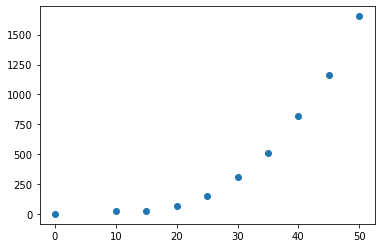

In [81]:
plt.scatter([i[0] for i in time_list],[i[1] for i in time_list])
plt.show()